### 1. Introduction

In this project, I will study COVID-19 cases and deaths in states of California and New York. Firstly, I want to find out the dates when each of the states had their highest number of new cases and new deaths. Then, I will fit a linear model to California COVID-19 data and see how well it performs on New York data.

### 2. Libraries

In [1]:
library(tidyverse)
library(lubridate)
library(ggplot2)
library(cowplot, warn.conflicts=FALSE)

options(warn=-1)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Warning message:
"package 'cowplot' was built under R version 4.3.3"


### 3. Importing Data

I used data from Johns Hopkins University that includes time series tables that document confirmed cases, and deaths from daily reports.

I will start by reading in the .csv files from the JHU github repository.

In [2]:
url_in <- "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/"

file_names <- c("time_series_covid19_confirmed_US.csv",
                "time_series_covid19_deaths_US.csv")

urls <- str_c(url_in, file_names)

In [3]:
US_cases <- read_csv(urls[1], show_col_types = FALSE)
US_deaths <- read_csv(urls[2], show_col_types = FALSE)

In [4]:
US_cases <- US_cases %>%
  pivot_longer(cols = -c(UID:Combined_Key),
               names_to = "date",
               values_to = "cases") %>%
  select(Admin2:cases) %>%
  mutate(date = mdy(date)) %>%
  select(-c(Lat, Long_))

US_deaths <- US_deaths %>%
  pivot_longer(cols = -c(UID:Population),
               names_to = "date",
               values_to = "deaths") %>%
  select(Admin2:deaths) %>%
  mutate(date = mdy(date)) %>%
  select(-c(Lat, Long_))

In [5]:
US <- US_cases %>%
  full_join(US_deaths)

Joining with `by = join_by(Admin2, Province_State, Country_Region, Combined_Key, date)`


Here, I scale the data by population and created a data set that showed the cases in each state.

In [6]:
US_by_state <- US %>%
  group_by(Province_State, Country_Region, date) %>%
  summarize(cases = sum(cases), deaths = sum(deaths), 
            Population = sum(Population)) %>%
  mutate(cases_per_mill = cases * 1000000 / Population) %>%
  mutate(deaths_per_mill = deaths * 1000000 / Population) %>%
  select(Province_State, Country_Region, date, cases, deaths, cases_per_mill,
         deaths_per_mill, Population) %>%
  ungroup()

`summarise()` has grouped output by 'Province_State', 'Country_Region'. You can override using the `.groups` argument.


I then made a dataset called US_totals that shows the number of cases and deaths throughout the whole US for each date.

In [7]:
US_totals <- US_by_state %>%
  group_by(Country_Region, date) %>%
  summarize(cases = sum(cases), deaths = sum(deaths),
            Population = sum(Population)) %>%
  mutate(cases_per_mill = cases * 1000000 / Population) %>%
  mutate(deaths_per_mill = deaths * 1000000 / Population) %>%
  select(Country_Region, date, cases, deaths, cases_per_mill, deaths_per_mill,
         Population) %>%
  ungroup()

`summarise()` has grouped output by 'Country_Region'. You can override using the `.groups` argument.


Since I ultimately want to train a model with California's COVID-19 data, I separate it out from US_by_state into its own dataset called CA_totals.


In [8]:
CA_totals <- US_by_state %>%
  filter(Province_State == "California") %>%
  group_by(Province_State, date) %>%
  summarize(cases = sum(cases), deaths = sum(deaths),
            Population = sum(Population)) %>%
  mutate(cases_scaled = cases * 1000 / Population) %>%
  mutate(deaths_scaled = deaths * 1000 / Population) %>%
  select(Province_State, date, cases, deaths, cases_scaled, deaths_scaled,
         Population) %>%
  ungroup()

`summarise()` has grouped output by 'Province_State'. You can override using the `.groups` argument.


Here, I do the same thing to separate out New York's COVID-19 data.


In [9]:
NY_totals <- US_by_state %>%
  filter(Province_State == "New York") %>%
  group_by(Province_State, date) %>%
  summarize(cases = sum(cases), deaths = sum(deaths),
            Population = max(Population)) %>%
  mutate(cases_scaled = cases * 1000 / Population) %>%
  mutate(deaths_scaled = deaths * 1000 / Population) %>%
  select(Province_State, date, cases, deaths, cases_scaled, deaths_scaled,
         Population) %>%
  ungroup()

`summarise()` has grouped output by 'Province_State'. You can override using the `.groups` argument.


After viewing the dataframes for each state, New York's data shows that it has instances of zero cases from mid-January of 2020 until early March. Since this might skew the data, I will remove instances of zero cases for both California and New York.

In [10]:
CA_totals <- CA_totals %>%
  filter(cases > 0)

NY_totals <- NY_totals %>%
  filter(cases > 0)

### 5. Some Analysis and Visualization

Before modeling, I will seek to answer the following questions:

1. What date did the US have the highest number of:
    a) Total Cases
    b) Total Deaths
2. What date did California and New York have the highest number of:
    a) Total Cases
    b) Total Deaths

Here, I calculate the new cases and new deaths for the US, California, and New York within the dataset.

In [11]:
CA_totals <- CA_totals %>%
  mutate(new_cases = cases - lag(cases),
         new_cases = replace_na(new_cases, 0),
         new_deaths = deaths - lag(deaths),
         new_deaths = replace_na(new_deaths, 0)) %>%
  filter(new_cases >= 0, new_deaths >= 0)

NY_totals <- NY_totals %>%
  mutate(new_cases = cases - lag(cases),
         new_cases = replace_na(new_cases, 0),
         new_deaths = deaths - lag(deaths),
         new_deaths = replace_na(new_deaths, 0)) %>%
  filter(new_cases >= 0, new_deaths >= 0)

US_totals <- US_totals %>%
  mutate(new_cases = cases - lag(cases),
         new_cases = replace_na(new_cases, 0),
         new_deaths = deaths - lag(deaths),
         new_deaths = replace_na(new_deaths, 0)) %>%
  filter(new_cases >= 0, new_deaths >= 0)

Here, I get the results and print them out.

In [12]:
CA_results <- CA_totals %>%
  group_by(Province_State) %>%
  summarise(maxNewCases = new_cases[which.max(new_cases)], 
            maxNewCasesDate = date[which.max(new_cases)],
            maxNewDeaths = new_deaths[which.max(new_deaths)],
            maxNewDeathsDate = date[which.max(new_deaths)],
            maxCases = cases[which.max(cases)],
            maxCasesDate = date[which.max(cases)],
            maxDeaths = deaths[which.max(deaths)],
            maxDeathsDate = date[which.max(deaths)],
            population = mean(Population))

NY_results <- NY_totals %>%
  group_by(Province_State) %>%
  summarise(maxNewCases = new_cases[which.max(new_cases)], 
            maxNewCasesDate = date[which.max(new_cases)],
            maxNewDeaths = new_deaths[which.max(new_deaths)],
            maxNewDeathsDate = date[which.max(new_deaths)],
            maxCases = cases[which.max(cases)],
            maxCasesDate = date[which.max(cases)],
            maxDeaths = deaths[which.max(deaths)],
            maxDeathsDate = date[which.max(deaths)],
            population = mean(Population))

results <- CA_results  %>%
  full_join(NY_results)

head(data.frame(results))

Joining with `by = join_by(Province_State, maxNewCases, maxNewCasesDate, maxNewDeaths, maxNewDeathsDate, maxCases,
maxCasesDate, maxDeaths, maxDeathsDate, population)`


,Province_State,maxNewCases,maxNewCasesDate,maxNewDeaths,maxNewDeathsDate,maxCases,maxCasesDate,maxDeaths,maxDeathsDate,population
,<chr>,<dbl>,<date>,<dbl>,<date>,<dbl>,<date>,<dbl>,<date>,<dbl>
1,California,207110,2022-01-16,1163,2021-02-24,12129699,2023-03-09,101159,2023-03-09,39512223
2,New York,132093,2022-01-03,1271,2020-04-07,6794738,2023-03-09,77157,2023-03-09,19453561


From the code and its output above, we can see that overall, California has more new cases, new deaths, max cases, and max deaths compared to New York. This is most likely due to the population differences between these two countries, and can also be due to other factors like COVID testing and reporting. We can see that New York reached its maximum number of new cases about three months after California reached its maximum new cases. Interestingly, New York reached its maximum number of new deaths quite early on into the pandemic, as opposed to California. 

Below are some plots to visualize this.

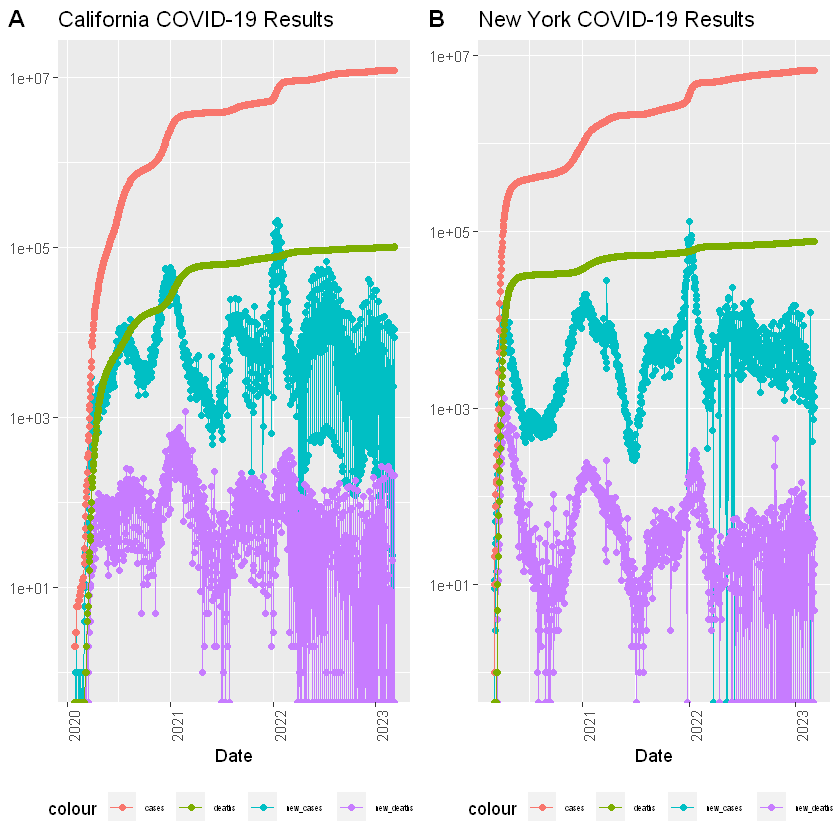

In [13]:
#US plots
CA_plot <- CA_totals %>%
  ggplot(aes(x = date, y = new_cases)) +
  geom_line(aes(color = "new_cases")) +
  geom_point(aes(color = "new_cases")) +
  geom_line(aes(y = new_deaths, color = "new_deaths")) +
  geom_point(aes(y = new_deaths, color = "new_deaths")) +
  geom_line(aes(y = cases, color = "cases")) +
  geom_point(aes(y = cases, color = "cases")) +
  geom_line(aes(y = deaths, color = "deaths")) +
  geom_point(aes(y = deaths, color = "deaths")) +
  scale_y_log10() +
  ggtitle("California COVID-19 Results") +
  labs(x = "Date", y = NULL) +
  theme(legend.position = "bottom",
        legend.text = element_text(size = 5),
        axis.text.x = element_text(angle = 90))

NY_plot <- NY_totals %>%
  ggplot(aes(x = date, y = new_cases)) +
  geom_line(aes(color = "new_cases")) +
  geom_point(aes(color = "new_cases")) +
  geom_line(aes(y = new_deaths, color = "new_deaths")) +
  geom_point(aes(y = new_deaths, color = "new_deaths")) +
  geom_line(aes(y = cases, color = "cases")) +
  geom_point(aes(y = cases, color = "cases")) +
  geom_line(aes(y = deaths, color = "deaths")) +
  geom_point(aes(y = deaths, color = "deaths")) +
  scale_y_log10() +
  ggtitle("New York COVID-19 Results") +
  labs(x = "Date", y = NULL) +
  theme(legend.position = "bottom",
        legend.text = element_text(size = 5),
        axis.text.x = element_text(angle = 90))

plot_grid(CA_plot, NY_plot, labels = "AUTO")

Looking at the above graphs side-by-side, we can see a few things. Firstly, we note at the start of the COVID-19 pandemic, both California and New York had a similar dramatic increases in cases, deaths, new cases, and new deaths. Both countries seem to have leveled out in total cases and deaths around the same time, although California's was more gradual and New York was sharper during the second half of 2020. Additionally, it's interesting to see that for both states, the trends for new cases and new deaths follow the same shapes.

Next, I want to see if there is some relationship when plotting new deaths versus new cases for each state.

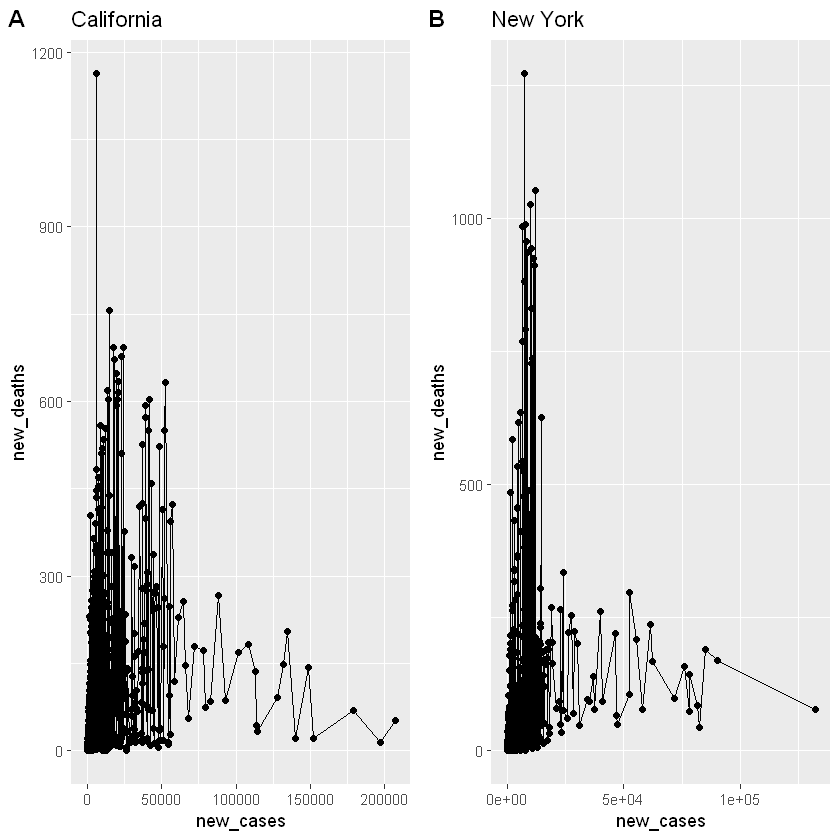

In [15]:
CA_plot_new <- CA_totals %>%
  ggplot(aes(x = new_cases, y = new_deaths)) +
  geom_line() +
  geom_point() +
  ggtitle("California") +
  theme(legend.position = "bottom")

NY_plot_new <- NY_totals %>%
  ggplot(aes(x = new_cases, y = new_deaths)) +
  geom_line() +
  geom_point() +
  ggtitle("New York") +
  theme(legend.position = "bottom")

plot_grid(CA_plot_new, NY_plot_new, labels = "AUTO")

From the graphs above, we can see that there is a general upward trend of new deaths with new cases, however the variance of new_deaths is pretty high for both California and New York.


### 6. Modeling

Now, I would like to train a linear model with California's COVID-19 data and see how well it works for the New York's data. I use deaths_scaled as my response and cases_scaled as my predictor. Recall that cases and deaths are scaled by 1000 and the respective populations for each state.


In [16]:
mod <- lm(deaths_scaled ~ cases_scaled , data = CA_totals)
summary(mod)

CA_pred <- predict(mod)

CA_totals <- CA_totals %>%
  mutate(prediction = CA_pred)


Call:
lm(formula = deaths_scaled ~ cases_scaled, data = CA_totals)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.3706 -0.2289 -0.1183  0.3540  0.5030 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3.706e-01  1.388e-02   26.69   <2e-16 ***
cases_scaled 7.913e-03  7.989e-05   99.05   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.2874 on 1123 degrees of freedom
Multiple R-squared:  0.8973,	Adjusted R-squared:  0.8972 
F-statistic:  9810 on 1 and 1123 DF,  p-value: < 2.2e-16


The output of the summary for the model shows that cases_scaled is a significant predictor and the adjusted R-squared is close to 1.

Next, I test the model on New York's data.

In [17]:
NY_pred <- predict(mod, newdata = NY_totals)

NY_totals <- NY_totals %>%
  mutate(prediction = NY_pred)

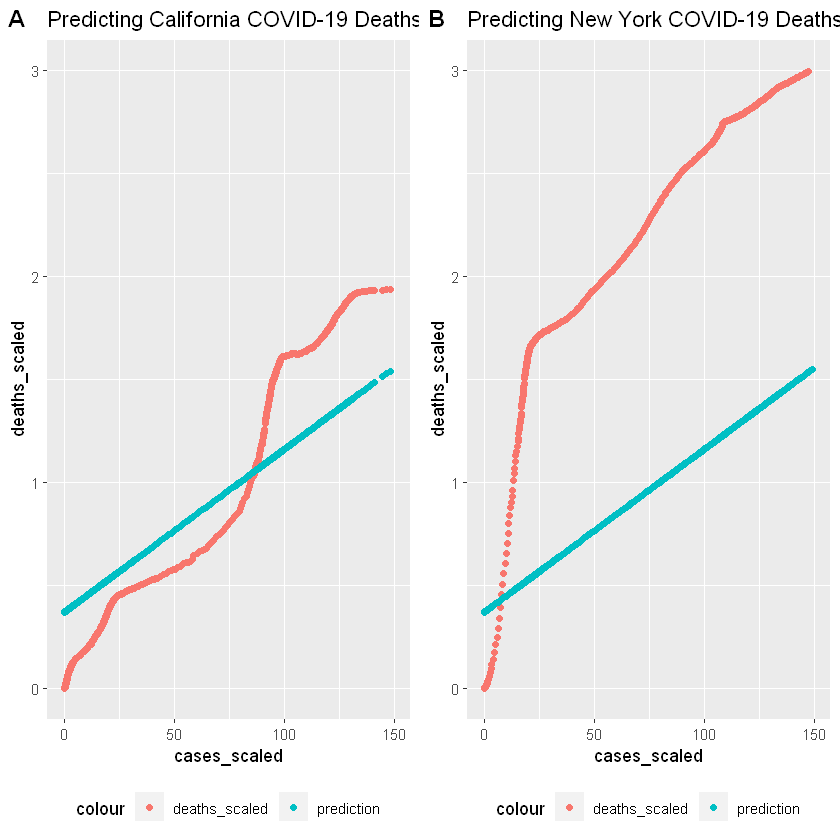

In [18]:
CA_model_plot <- ggplot(CA_totals, aes(x = cases_scaled, y = deaths_scaled)) +
  geom_point(aes(color = "deaths_scaled")) +
  geom_point(aes(y = prediction, color = "prediction")) +
  ggtitle("Predicting California COVID-19 Deaths") +
  theme(legend.position = "bottom") +
  scale_x_continuous(limits = c(0, 150)) +
  scale_y_continuous(limits = c(0, 3))

NY_model_plot <- ggplot(NY_totals, aes(x = cases_scaled, y = deaths_scaled)) +
  geom_point(aes(color = "deaths_scaled")) +
  geom_point(aes(y = prediction, color = "prediction")) +
  ggtitle("Predicting New York COVID-19 Deaths") +
  theme(legend.position = "bottom") +
  scale_x_continuous(limits = c(0, 150)) +
  scale_y_continuous(limits = c(0, 3))

plot_grid(CA_model_plot, NY_model_plot, labels = "AUTO")

Below I return the R-squared value for the model trained on California's data. Then I calculate the residual sum of squares and total sum of squares to ultimately calculate the R-squared value of the tested New York data.


In [19]:
CA_r2 <- summary(mod)$r.squared

NY_true <- NY_totals$deaths_scaled

SS_resid <- sum((NY_true - NY_pred)^2)
SS_total <- sum((NY_true - mean(NY_true))^2)

NY_r2 <- 1 - (SS_resid / SS_total)

In [20]:
CA_r2
NY_r2

[1] 0.8972864

[1] -0.4604249

After training the model on the California COVID-19 data we can see that the model fits the data pretty well when scaled cases are under 25 or above 100. It does not really do a good job of fitting when cases are in between those numbers. However, the R-squared value generated by the linear model for California is very high, close to 1.

When testing this model on New York's COVID-19 data, we see that the model severely underfits New York's data. Plotting the two regression graphs side-by-side shows that California overall has less cases and deaths when scaled by 1000 with respect to population compared to New York. So, as New York's scaled cases increase, the scaled deaths increase at a sharper rate, which is why California's model failed to work for New York. The model's prediction for an appropriate intercept for California is not large enough to account for the steeper rate needed for New York. This is also evident by the negative R-squared value when testing the California model on New York.


### 7. Conclusion and Bias Discussion

COVID-19 has drastically affected the whole world over the last couple years. All countries are facing this pandemic with whatever resources they have or are able to acquire, with respect to their own needs. Even across the US, different states have varying plans of action with regards to COVID-19, which in turn can show different levels of growth for both cases and deaths.

An attempt to model California's deaths and cases and apply it to New York's data shows that two of the largest states in the US are not necessarily having the same outcomes with this pandemic. The only factors taken into account in this model are cases, deaths, and populations. So, the model does not take into account why California's data behaves one way, and New York's data another way.

This is where the topic of bias plays an important role. Fitting a model on one state like California and using it as the gold standard across other states would not be accurate. Although the model may fit decently well with a high R-squared value for California, does not mean it will work well for other states. There are many factors as to why cases and deaths vary between states. Differences in the reporting of cases or deaths, state regulations, compliance of residents to socially distance and wear masks, vaccination rates, and hospitalization, to name a few, are underlying causes as to why cases and deaths differ between states. Training a model based on one state and using it as the "ideal model" compared to other states, creates a biased model if underlying reasons for differences are not accounted for or standardized in some way. In the case of this project, only deaths, cases, and population played role. Perhaps the modeling would turn out differently if other predictors like some of the ones previously mentioned are added.